In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import simps, trapz, cumtrapz
from scipy.ndimage.filters import gaussian_filter1d
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 9]

In [2]:
co2_data = pd.read_csv('c02.txt', sep = '\t')
co2_data['P'] = co2_data['Pressure (bar)']
co2_data['T'] = co2_data['Temperature (K)']
co2_data['V'] = co2_data['Volume (l/mol)']
co2_data['Z'] = co2_data.V * co2_data.P/(.08314)/(318.15)
exp = ( co2_data.Z - 1 )/co2_data.P
integral = cumtrapz( exp, co2_data.P)
thiele = np.exp( integral )
thiele = np.insert(thiele, 0,1)
co2_data['F'] = thiele*co2_data.P

me_data = pd.read_csv('ch4.txt', sep = '\t')
me_data['P'] = me_data['Pressure (bar)']
me_data['T'] = me_data['Temperature (K)']
me_data['V'] = me_data['Volume (l/mol)']
me_data['Z'] = me_data.V * me_data.P/(.08314)/(318.15)
exp = ( me_data.Z - 1 )/me_data.P
integral = cumtrapz( exp, me_data.P)
thiele = np.exp( integral )
thiele = np.insert(thiele, 0,1)
me_data['F'] = thiele*me_data.P

In [17]:
def kappa(ohm):
    return 0.37464 + 1.5422*ohm - 0.26992*ohm**2

def alpha(kappa, Tc, T):
    return ( 1 + kappa*(1 - np.sqrt(T/Tc) ) )**2

def a( Tc, Pc, alpha, P_res, T ):
    R = .08314 #L*bar/mol/K
    return 0.45724*R**2*Tc**2*alpha/Pc

def A( a, P_res, T ):
    R = .08314 #L*bar/mol/K
    return a*P_res/R**2/T**2

def b( Tc, Pc ):
    R = .08314 #L*bar/mol/K
    return 0.07780*R*Tc/Pc

def B( b, P_res, T):
    R = .08314 #L*bar/mol/K
    return b*P_res/R/T

def solveZ( A, B ):
    c1 = B-1
    c2 = A - 3*B**2 - 2*B
    c3 = B**3 + B**2 - A*B
    roots = np.roots( [1, c1, c2, c3] )
    for r in roots:
        if( r.imag == 0):
            return( r.real )
    else:
        stop()
        
        
def Fi( Aii, Ajj, Aij, A_mix, Bi, B_mix, Z_mix, yi, P_res ):
    term1 = Bi*(Z_mix - 1)/B_mix
    term2 = np.log( Z_mix - B_mix )
    term3 = A_mix/( 2*np.sqrt(2)*B_mix )
    term4 = 2*( yi*Aii + (1-yi)*Aij )/A_mix - Bi/B_mix
    term5 = (Z_mix + (1 + np.sqrt(2))*B_mix )/(Z_mix + (1 - np.sqrt(2))*B_mix )
    term6 = term1 - term2 - term3*term4*np.log( term5 )
    return yi*P_res*np.exp( term6 )

def Fone( Z, A, B, P_res):
    term1 = Z - 1 - np.log( Z - B)
    term2 = A/( 2*np.sqrt(2)*B )
    term3 = (Z + (1 + np.sqrt(2))*B )/(Z + (1 - np.sqrt(2))*B )
    term4 = term1 - term2*np.log( term3 )
    return np.exp( term4 )*P_res

def PR_Fugacity( P_res, T, yco):
    Tc_co = 304.2 #K
    Tc_me = 190.6 #K
    Pc_co = 73.76 #bar
    Pc_me = 46 #bar
    ohm_co = 0.225
    ohm_me = 0.008
    
    kappa_me = kappa( ohm_me )
    alpha_me = alpha( kappa_me, Tc_me, T)
    a_me = a( Tc_me, Pc_me, alpha_me, P_res, T )
    A_me = A( a_me, P_res, T )
    b_me = b( Tc_me, Pc_me )
    B_me = B( b_me, P_res, T)

    kappa_co = kappa( ohm_co )
    alpha_co = alpha( kappa_co, Tc_co, T)
    a_co = a( Tc_co, Pc_co, alpha_co, P_res, T )
    A_co = A( a_co, P_res, T )
    b_co = b( Tc_co, Pc_co )
    B_co = B( b_co, P_res, T)
    
    a_cm = np.sqrt(a_me*a_co )*(1-0.0919)
    A_cm = A( a_cm, P_res, T)

    a_mix = yco*yco*a_co + 2*yco*(1-yco)*a_cm + (1-yco)*(1-yco)*a_me
    b_mix = yco*b_co + (1-yco)*b_me

    A_mix = A( a_mix, P_res, T )
    B_mix = B( b_mix, P_res, T )
    Z_mix = solveZ( A_mix, B_mix )
    
    F_me = Fi( A_me, A_co, A_cm, A_mix, B_me, B_mix, Z_mix, 1-yco, P_res)
    F_co = Fi( A_co, A_me, A_cm, A_mix, B_co, B_mix, Z_mix, yco, P_res)
    
    return F_co, F_me

def PR_Fugacity_Single( P_res, T, species):
    Tc_co = 304.2 #K
    Tc_me = 190.6 #K
    Pc_co = 73.76 #bar
    Pc_me = 46 #bar
    ohm_co = 0.225
    ohm_me = 0.008
    
    if (species == "co"):
        kappa_co = kappa( ohm_co )
        alpha_co = alpha( kappa_co, Tc_co, T)
        a_co = a( Tc_co, Pc_co, alpha_co, P_res, T )
        A_co = A( a_co, P_res, T )
        b_co = b( Tc_co, Pc_co )
        B_co = B( b_co, P_res, T)
        Z_co = solveZ( A_co, B_co )
        return Fone( Z_co, A_co, B_co, P_res )
        
    elif (species == "me"):
        kappa_me = kappa( ohm_me )
        alpha_me = alpha( kappa_me, Tc_me, T)
        a_me = a( Tc_me, Pc_me, alpha_me, P_res, T )
        A_me = A( a_me, P_res, T )
        b_me = b( Tc_me, Pc_me )
        B_me = B( b_me, P_res, T)
        Z_me = solveZ( A_me, B_me )
        return Fone( Z_me, A_me, B_me, P_res )
    
    else:
        stop("unknown species")
        

In [18]:
P_res = 100 #bar
T = 318.15 #K
yco = 0.5
yme = 1-yco

Tc_co = 304.2 #K
Tc_me = 190.6 #K
Pc_co = 73.76 #bar
Pc_me = 46 #bar
ohm_co = 0.225
ohm_me = 0.008
    
kappa_me = kappa( ohm_me )
alpha_me = alpha( kappa_me, Tc_me, T)
a_me = a( Tc_me, Pc_me, alpha_me, P_res, T )
A_me = A( a_me, P_res, T )
print( "A_me: " +  str( round(A_me, 4) ) )
b_me = b( Tc_me, Pc_me )
B_me = B( b_me, P_res, T)
print( "B_me: " +  str( round(B_me, 4) ) )

kappa_co = kappa( ohm_co )
alpha_co = alpha( kappa_co, Tc_co, T)
a_co = a( Tc_co, Pc_co, alpha_co, P_res, T )
A_co = A( a_co, P_res, T )
print( "A_co: " +  str( round(A_co, 4) ) )
b_co = b( Tc_co, Pc_co )
B_co = B( b_co, P_res, T)
print( "B_co: " +  str( round(B_co, 4) ) )
    
a_cm = np.sqrt(a_me*a_co )*(1-0.0919)
A_cm = A( a_cm, P_res, T)
print( "A_cm: " +  str( round(A_cm, 4) ) )

a_mix = yco*yco*a_co + 2*yco*(1-yco)*a_cm + (1-yco)*(1-yco)*a_me
b_mix = yco*b_co + (1-yco)*b_me

A_mix = A( a_mix, P_res, T )
print( "A_mix: " +  str( round(A_mix, 4) ) )
B_mix = B( b_mix, P_res, T )
print( "B_mix: " +  str( round(B_mix, 4) ) )
Z_mix = solveZ( A_mix, B_mix )
print( "Z_mix: " +  str( round(Z_mix, 4) ) )
    
F_me = Fi( A_me, A_co, A_cm, A_mix, B_me, B_mix, Z_mix, 1-yco, P_res)
#F_co = Fi( A_co, A_me, A_cm, A_mix, B_co, B_mix, Z_mix, yco, P_res)

F_me
#print( F_me )

A_me: 0.2807
B_me: 0.1013
A_co: 0.5487
B_co: 0.1009
A_cm: 0.3564
A_mix: 0.3855
B_mix: 0.1011
Z_mix: 0.7437


44.60154543726896

In [19]:
( Z_mix + (1+np.sqrt(2))*B_mix )/( Z_mix + (1-np.sqrt(2))*B_mix)

1.4073898804297278

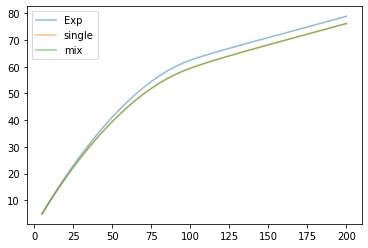

In [20]:
# Pure Component Fugacities
species = "co"
T = 318.15 #K

Pv = np.linspace( 5, 200, 40 )
Fv_one = np.zeros( 40 )
Fv_mix = np.zeros( 40 )

for i in np.arange(40):
    Fv_one[i] = PR_Fugacity_Single( Pv[i], T, species)
    Fv_mix[i], _ = PR_Fugacity( Pv[i], T, 1 )
    
select = co2_data[ co2_data.P <= 200 ]
plt.plot( "P", "F", data = select, label = "Exp", alpha = 0.5)
plt.plot( Pv, Fv_one, label = "single", alpha = 0.5)
plt.plot( Pv, Fv_mix, label = "mix", alpha = 0.5)
plt.legend()

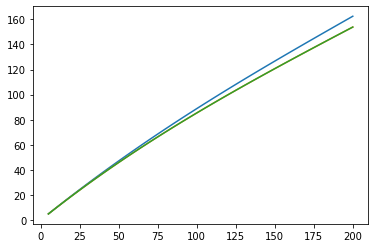

In [21]:
# Pure Component Fugacities
species = "me"
T = 318.15 #K

Pv = np.linspace( 5, 200, 40 )
Fv_one = np.zeros( 40 )
Fv_mix = np.zeros( 40 )

for i in np.arange(40):
    Fv_one[i] = PR_Fugacity_Single( Pv[i], T, species)
    _ , Fv_mix[i] = PR_Fugacity( Pv[i], T, 0 )
    
select = me_data[ me_data.P <= 200 ]
plt.plot( "P", "F", data = select, label = "Exp")
plt.plot( Pv, Fv_one, label = "single")
plt.plot( Pv, Fv_mix, label = "mix")

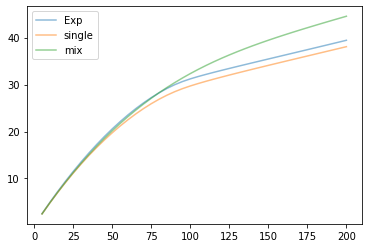

In [22]:
# Mixture Component Fugacities
species = "co"
T = 318.15 #K
yco = 0.5

Pv = np.linspace( 5, 200, 40 )
Fv_one = np.zeros( 40 )
Fv_mix = np.zeros( 40 )

for i in np.arange(40):
    Fv_one[i] = yco*PR_Fugacity_Single( Pv[i], T, species)
    Fv_mix[i], _ = PR_Fugacity( Pv[i], T, yco )
    
select = co2_data[ co2_data.P <= 200 ]
plt.plot( select.P, yco*select.F, label = "Exp", alpha = 0.5)
plt.plot( Pv, Fv_one, label = "single", alpha = 0.5)
plt.plot( Pv, Fv_mix, label = "mix", alpha = 0.5)
plt.legend()

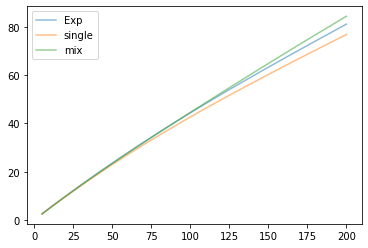

In [23]:
# Mixture Component Fugacities
species = "me"
T = 318.15 #K
yco = 0.5

Pv = np.linspace( 5, 200, 40 )
Fv_one = np.zeros( 40 )
Fv_mix = np.zeros( 40 )

for i in np.arange(40):
    Fv_one[i] = (1-yco)*PR_Fugacity_Single( Pv[i], T, species)
    _ , Fv_mix[i] = PR_Fugacity( Pv[i], T, yco )
    
select = me_data[ me_data.P <= 200 ]
plt.plot( select.P, (1-yco)*select.F, label = "Exp", alpha = 0.5)
plt.plot( Pv, Fv_one, label = "single", alpha = 0.5)
plt.plot( Pv, Fv_mix, label = "mix", alpha = 0.5)
plt.legend()

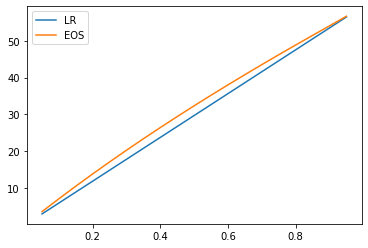

In [24]:
yv = np.linspace( 0.05, .95, 19 )
P = 100

Fv_one = np.zeros( 19 )
Fv_mix = np.zeros( 19 )

for i in np.arange(19):
    Fv_one[i] = yv[i]*PR_Fugacity_Single( P, T, "co")
    Fv_mix[i] , _ = PR_Fugacity( P, T, yv[i] )

plt.plot( yv, Fv_one, label = "LR" )
plt.plot( yv, Fv_mix, label = "EOS")
plt.legend()

In [25]:
compare = pd.DataFrame()
compare['yco'] = yv
compare['Fco_LR'] = Fv_one
compare['Fco_EOS'] = Fv_mix
compare

,yco,Fco_LR,Fco_EOS
0,0.05,2.970853,3.596332
1,0.10,5.941705,7.100062
2,0.15,8.912558,10.516253
3,0.20,11.883411,13.849656
4,0.25,14.854264,17.104747
5,0.30,17.825116,20.285756
6,0.35,20.795969,23.396694
7,0.40,23.766822,26.441382
8,0.45,26.737675,29.423481
9,0.50,29.708527,32.346519


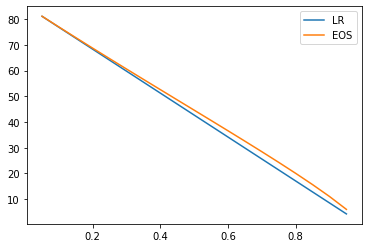

In [26]:
yv = np.linspace( 0.05, .95, 19 )
P = 100

Fv_one = np.zeros( 19 )
Fv_mix = np.zeros( 19 )

for i in np.arange(19):
    Fv_one[i] = (1-yv[i])*PR_Fugacity_Single( P, T, "me")
    _ , Fv_mix[i] = PR_Fugacity( P, T, yv[i] )

plt.plot( yv, Fv_one, label = "LR" )
plt.plot( yv, Fv_mix, label = "EOS")
plt.legend()

In [27]:
compare['Fme_LR'] = Fv_one
compare['Fme_EOS'] = Fv_mix
compare[['yco','Fco_LR', "Fme_LR", "Fco_EOS", "Fme_EOS"]]

,yco,Fco_LR,Fme_LR,Fco_EOS,Fme_EOS
0,0.05,2.970853,81.113845,3.596332,81.141594
1,0.10,5.941705,76.844696,7.100062,76.951935
2,0.15,8.912558,72.575546,10.516253,72.808414
3,0.20,11.883411,68.306396,13.849656,68.705414
4,0.25,14.854264,64.037246,17.104747,64.637234
5,0.30,17.825116,59.768097,20.285756,60.598011
6,0.35,20.795969,55.498947,23.396694,56.581624
7,0.40,23.766822,51.229797,26.441382,52.581570
8,0.45,26.737675,46.960647,29.423481,48.590807
9,0.50,29.708527,42.691498,32.346519,44.601545
